In [2]:
%load_ext watermark
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
from IPython.display import Markdown as md

from plastockmethods import name_the_zones, name_the_particles, frequentation_name, situation_name
from plastockmethods import particle_groups, name_the_substrate, name_the_distance, table_css_styles

a_property =  {'color' : 'red'}

def translate_describe(x, value_column):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    
    return df
def add_labels_display(data, column_name, labels):
    # Changes column values from integer to labels and sets df.index to column_name
    data[column_name] = data[column_name].apply(lambda x: labels[x])
    data.set_index(column_name, drop=True, inplace=True)
    data.index.name = None
        
    return data.style.format(precision=2).set_table_styles(table_css_styles)
def normalize_column(x):
    return (x - x.min())/(x.max()-x.min())

def attribute_summary(some_data, vals, voi, columns: dict = None, labels: dict = None):
    
    groupby = ['echantillon', voi]
    data = some_data.groupby(groupby, as_index=False)[vals].sum()
    data[voi] = data[voi].apply(lambda x: labels[x])

    data_summary = data.groupby(voi, as_index=False)[vals].describe()
    data_summary[['count', 'max', 'min']] = data_summary[['count', 'max', 'min']].astype('int')
    data_summary.rename(columns=columns, inplace=True)
    data_summary.set_index(voi, inplace=True, drop=True)
    data_summary.index.name = None
    
    select_values = data_summary["moyenne"] > 180
    test_one = data_summary.loc[select_values].index
    
    select_values = data_summary["50%"] > 121
    test_two = data_summary.loc[select_values].index
        
    d_sum = data_summary.style.set_table_styles(table_css_styles).format(precision=2)
    d_sum = d_sum.set_properties(subset = pd.IndexSlice[test_one,["moyenne"]], **a_property)
    
    return d_sum.set_properties(subset = pd.IndexSlice[test_two,["50%"]], **a_property)

def attribute_summary_grid(data, vals, voi, labels: dict=None, stat="probability"):
    
    groupby = ['echantillon', voi]
    some_data = data.groupby(groupby, as_index=False)[vals].sum()
    some_data[voi] = some_data[voi].apply(lambda x: labels[x])
    
    fig, axs = plt.subplots(2,2, figsize=(8,7))

    sns.scatterplot(some_data,x="echantillon", y=vals, hue=voi,  ax=axs[0,0])
    sns.boxplot(some_data, x=voi, y=vals, hue=voi, showfliers=False, ax=axs[1,0], dodge=False)
    sns.histplot(some_data,x=vals, hue=voi, ax=axs[0,1], stat=stat)
    sns.ecdfplot(some_data, x=vals, hue=voi, ax=axs[1,1])
    axs[0,0].set_ylim(-1, 1000)
    axs[0,1].set_xlim(-1, 1000)
    axs[1,1].set_xlim(-1, 1000)
    axs[0,0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    axs[0,0].set_xlabel("échantillon")
    axs[0,0].set_ylabel("particules")
    axs[0,0].get_legend().remove()
    axs[1,0].get_legend().remove()
    axs[1,0].set_xlabel("")
    axs[1,0].set_ylabel("particules")
    axs[0,1].set_xlabel("")
    axs[0,1].set_ylabel("probabilité")
    axs[1,0].tick_params(axis="x", rotation=90, )
    axs[1,1].get_legend().remove()
    axs[1,1].set_xlabel("")
    plt.subplots_adjust(wspace=.3)

    plt.tight_layout
    plt.show()


work_data = pd.read_csv("data/end_pipe/long_form_micro.csv")
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")

In [16]:
work_data.head()

,Plage,echantillon,orientation,position,substrat,frequentation,situation,distance,objet,compte
0,Amphion,74_Amp_1,NE,1,4,3,1,1,fibres,97
1,Amphion,74_Amp_10,NNE,2,4,3,1,1,fibres,140
2,Amphion,74_Amp_2,NNE,1,4,3,1,1,fibres,121
3,Amphion,74_Amp_3,NE,1,4,3,1,1,fibres,31
4,Amphion,74_Amp_4,NNE,1,4,3,1,1,fibres,179


# Microplastiques plage et attribut

Les attributs sont les caractéristiques du lieu d'étude qui changent d'un lieu à l'autre. La manière dont le nombre de microplastiques observés évolue en fonction des attributs est l'une des préoccupations de cette étude.

## Substrat

Le substrat définit la surface de l'emplacement d'échantillonnage.

In [27]:
columns = ['Plage', 'echantillon', 'orientation', 'position', 'substrat','frequentation', 'situation', 'distance', "fibres", "fdure", "souple", "fragments", "added"]
column_display = {
    "count":"n échantillons",
    "mean": "moyenne",
    "std": "écart type",
    "echantillon":"échantillon"
}

# ananlysis of substrat
voi = "substrat"
vals = "compte"
groupbys = ['echantillon', voi]
labels = name_the_substrate
format_kwargs = dict(precision=2, thousands="'", decimal=",")

substrat_summary = attribute_summary(work_data, vals, voi, columns=column_display, labels=name_the_substrate)

table_no = 1
figure_no = 1

def add_table_to_page(table, table_no, caption, section, page, rule):
    
    caption = f'Table {section}{page}-{table_no}: {caption} {rule}'
    table = table.format_index(str.title, axis=1).format_index(str.title, axis=0).format(**format_kwargs)
    return table.set_caption(caption)
caption = 'Le résumé des résultats du nombre de particules trouvées dans chaque échantillon pour chaque substrat.'
section = 'A'
rule = 'Les attributs dont la moyenne des résultats est supérieure à la moyenne du projet sont en rouge.'
page = 2

table_one = add_table_to_page(substrat_summary, table_no, caption, section, page, rule)
glue('table-one', table_one, display=False)

,N Échantillons,Moyenne,Écart Type,Min,25%,50%,75%,Max
Galet,46,"125,20","107,16",26,"57,50","92,50","155,75",665
Gravier,29,"335,59","622,59",0,"62,00","90,00","230,00",2'991
Sable Fin,114,"169,69","155,16",0,"82,75","132,00","200,00",971
Sable Grosssier,28,"151,89","136,76",19,"56,50","122,00","174,50",550


```{glue:} table-one
```

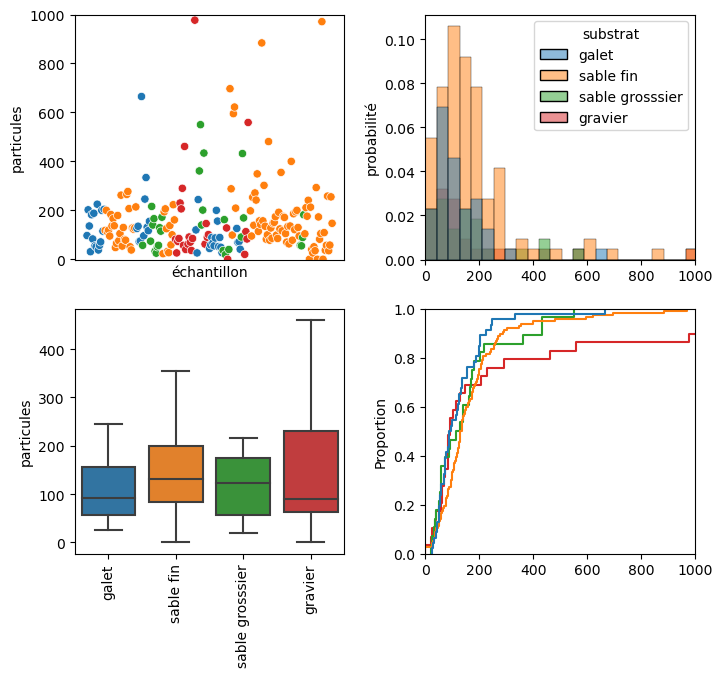

In [3]:
attribute_summary_grid(work_data, vals, voi, labels=labels)

### Les plages substrat = gravier

In [4]:
md(', '.join(work_data[work_data.substrat.isin([3])].Plage.unique()))

Hermance, Port Choiseul, Versoix, Cully, Pichette

### Les plages substrat = sable fin

In [5]:
md(', '.join(work_data[work_data.substrat.isin([1])].Plage.unique()))

Excenevex, Baby Plage, Grangettes, Préverenges, Rolle, Vidy, Bouveret

### Les plages substrat = sable grossier

In [6]:
md(', '.join(work_data[work_data.substrat.isin([2])].Plage.unique()))

Meillerie, Tougues, Savonnière, Clarens, Crans, Gland, Lutry, Tolochenaz

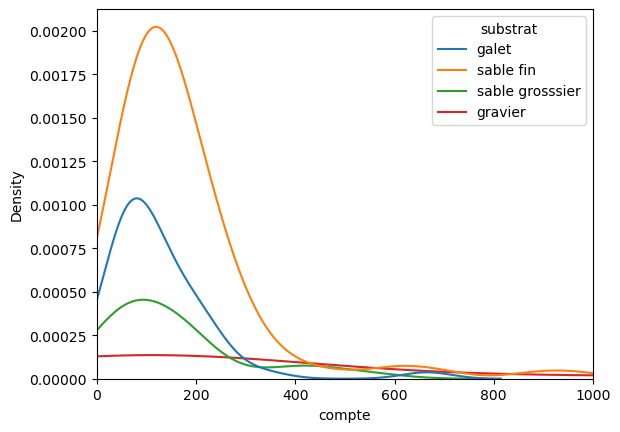

In [8]:
fig, ax = plt.subplots()
data = work_data.groupby(groupbys, as_index=False)[vals].sum()
data[voi] = data[voi].apply(lambda x: labels[x])

sns.kdeplot(data, x=vals, hue=voi, ax=ax, bw_adjust=1)
ax.set_xlim(0, 1000)
plt.show()

## Frequentation

In [29]:
# ananlysis of frequentation
voi = "frequentation"
vals = "compte"
groupbys = ['echantillon', voi]
labels = frequentation_name


freq = attribute_summary(work_data, vals, voi, columns=column_display, labels=labels)

caption = 'Le résumé des résultats du nombre de particules trouvées pour chaque niveau de fréquentation.'
table_no += 1

table_two = add_table_to_page(freq, table_no, caption, section, page, rule)
glue('table-two', table_two, display=False)

,N Échantillons,Moyenne,Écart Type,Min,25%,50%,75%,Max
Faible,8,"73,38","58,85",0,"46,00","57,00","98,75",182
Moyenne,37,"267,84","497,49",20,"72,00","117,00","209,00",2'991
Élévée,172,"166,23","189,29",0,"71,50","124,50","194,00",1'492


```{glue:} table-two
```

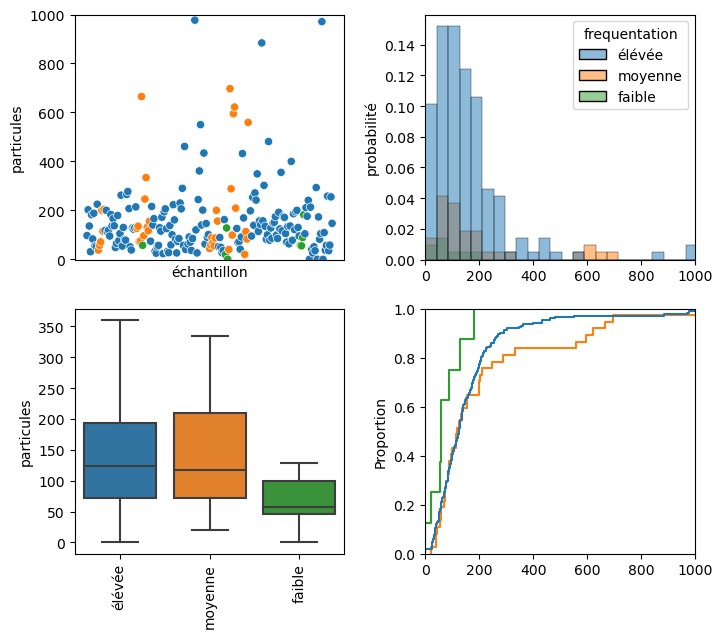

In [9]:
attribute_summary_grid(work_data, vals, voi, labels=labels)

### Les plages fréquentation = moyenne

In [10]:
md(', '.join(work_data[work_data.frequentation.isin([2])].Plage.unique()))

Anthy, Lugrin, Saint-Disdille, Aubonne, Gland, Grangettes, Pichette

### Les plages fréquentation = élevée

In [11]:
md(', '.join(work_data[work_data.frequentation.isin([3])].Plage.unique()))

Amphion, Excenevex, Tougues, Baby Plage, Hermance, Port Choiseul, Savonnière, Versoix, Clarens, Lutry, Préverenges, Rolle, Vidy, Bouveret

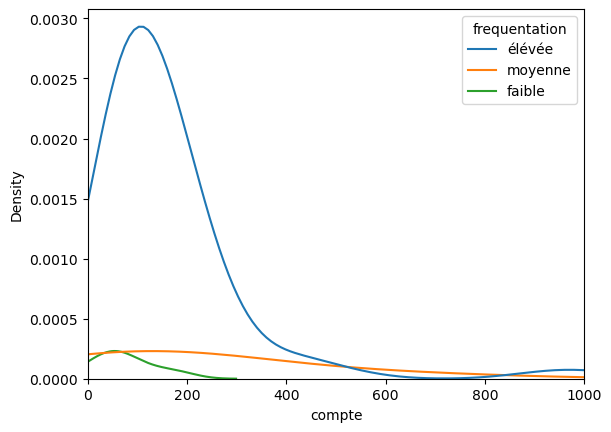

In [12]:
fig, ax = plt.subplots()

data = work_data.groupby(groupbys, as_index=False)[vals].sum()
data[voi] = data[voi].apply(lambda x: labels[x])

sns.kdeplot(data, x=vals, hue=voi, ax=ax)
ax.set_xlim(0, 1000)
plt.show()

## Situation

In [30]:
# ananlysis of situation
voi = "situation"
vals = "compte"
groupby = ['echantillon', voi]
labels = situation_name

sit = attribute_summary(work_data, vals, voi, columns=column_display, labels=labels)

caption = 'Le résumé des résultats du nombre de particules trouvées pour chaque situation: urbain, campagne.'
table_no += 1

table_three = add_table_to_page(sit, table_no, caption, section, page, rule)
glue('table-three', table_three, display=False)

,N Échantillons,Moyenne,Écart Type,Min,25%,50%,75%,Max
Campagne,140,"186,41","286,49",0,"75,75","128,00","200,00",2'991
Urbain,77,"168,71","230,73",0,"59,00","104,00","192,00",1'492


```{glue:} table-three
```

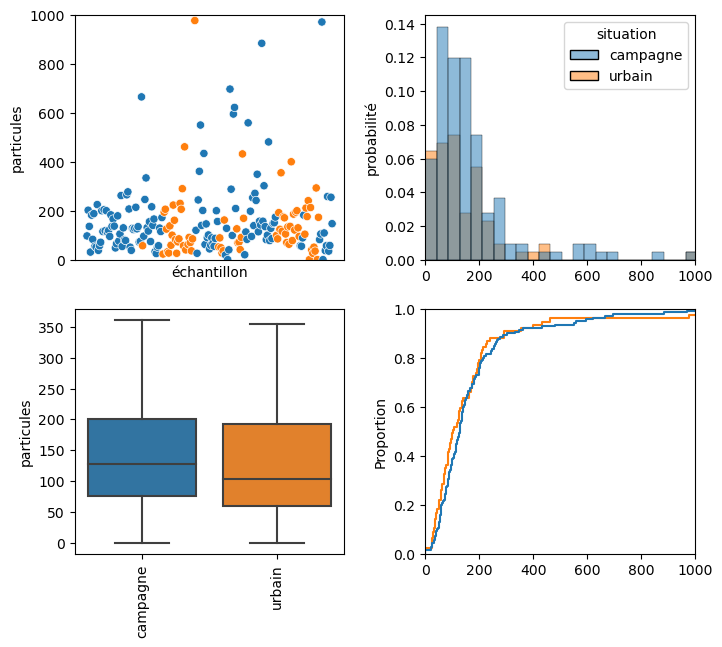

In [14]:
attribute_summary_grid(work_data, vals, voi, labels=labels)

### Les plages situation = campagne

In [15]:
md(', '.join(work_data[work_data.situation.isin([1])].Plage.unique()))

Amphion, Anthy, Excenevex, Lugrin, Saint-Disdille, Tougues, Savonnière, Versoix, Aubonne, Crans, Cully, Gland, Grangettes, Pichette, Préverenges, Tolochenaz, Bouveret

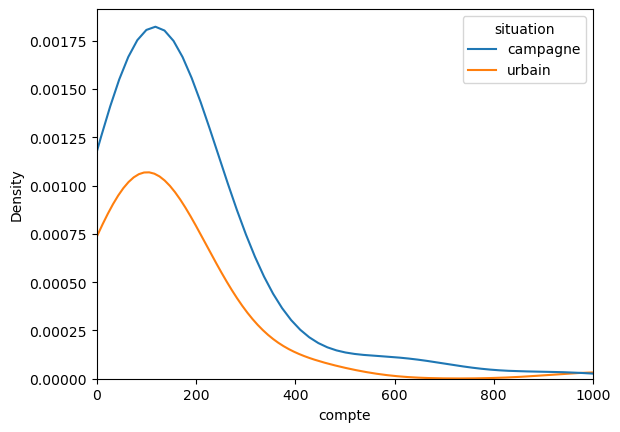

In [16]:
fig, ax = plt.subplots()

data = work_data.groupby(groupby, as_index=False)[vals].sum()
data[voi] = data[voi].apply(lambda x: situation_name[x])

sns.kdeplot(data, x=vals, hue=voi, ax=ax)
ax.set_xlim(0, 1000)
plt.show()

## Distance

In [31]:
# ananlysis of distance
voi = "distance"
vals = "compte"
groupby = ['echantillon', voi]
labels = name_the_distance

dist = attribute_summary(work_data, vals, voi, columns=column_display, labels=labels)

caption = 'Le résumé des résultats du nombre de particules trouvées selon le distance du parking.'
table_no += 1

table_four = add_table_to_page(dist, table_no, caption, section, page, rule)
glue('table-four', table_four, display=False)

,N Échantillons,Moyenne,Écart Type,Min,25%,50%,75%,Max
100 - 500M,110,"194,82","240,05",0,"70,50","126,00","210,50",1'492
500 - 1000M,2,"38,00","26,87",19,"28,50","38,00","47,50",57
< 100M,93,"176,81","312,85",0,"78,00","124,00","192,00",2'991
> 1000M,12,"95,00","53,75",44,"56,50","77,00","105,75",200


```{glue:} table-four
```

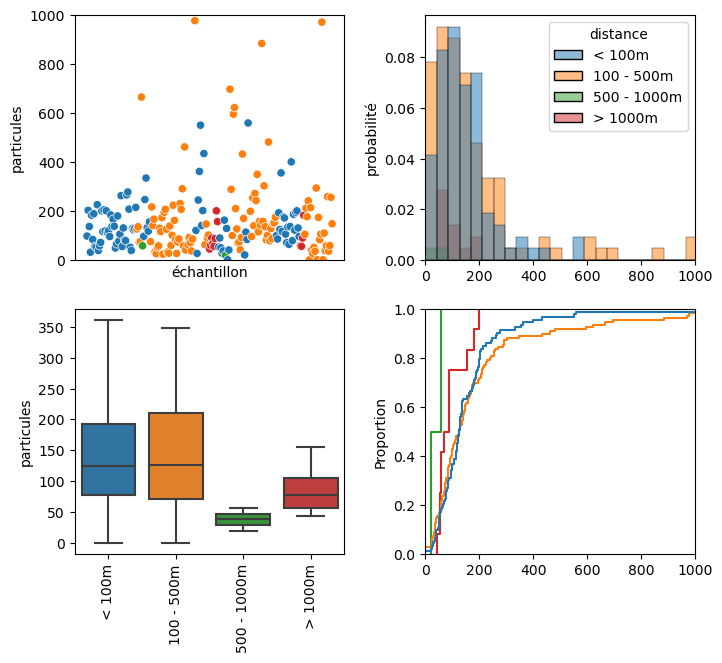

In [18]:
attribute_summary_grid(work_data, vals, voi, labels=labels)

### Les plages distance = 100 - 500m 

In [19]:
md(', '.join(work_data[work_data.distance.isin([2])].Plage.unique()))

Lugrin, Tougues, Baby Plage, Hermance, Port Choiseul, Versoix, Grangettes, Lutry, Préverenges, Vidy, Bouveret

### Les plages distance = < 100m  

In [20]:
md(', '.join(work_data[work_data.distance.isin([1])].Plage.unique()))

Amphion, Anthy, Excenevex, Saint-Disdille, Savonnière, Clarens, Cully, Gland, Pichette, Rolle

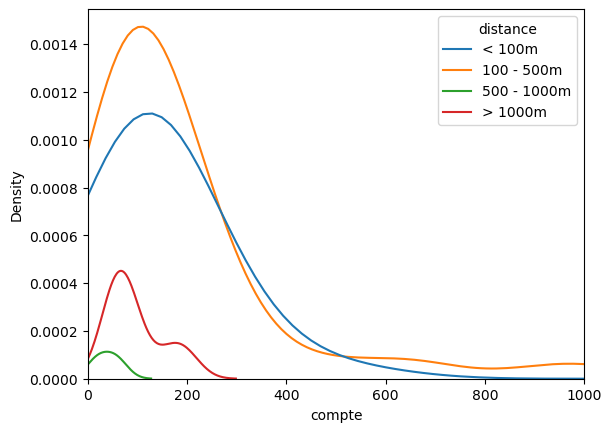

In [21]:
fig, ax = plt.subplots()

data = work_data.groupby(groupby, as_index=False)[vals].sum()
data[voi] = data[voi].apply(lambda x: labels[x])

sns.kdeplot(data, x=vals, hue=voi, ax=ax)
ax.set_xlim(0, 1000)
plt.show()

## Orientation

In [32]:
# ananlysis of substrat
voi = "orientation"
vals = "compte"
groupby = ['echantillon', voi]

data = work_data.groupby(groupby, as_index=False)[vals].sum()
# data[voi] = data[voi].apply(lambda x: situation_name[x])

data_summary = data.groupby(voi, as_index=False)[vals].describe()
data_summary[['count', 'max', 'min']] = data_summary[['count', 'max', 'min']].astype('int')
data_summary.rename(columns=column_display, inplace=True)
data_summary.set_index("orientation", inplace=True, drop=True)
data_summary.index.name = None

select_values = data_summary["moyenne"] > 180
test_one = data_summary.loc[select_values].index

select_values = data_summary["50%"] > 121
test_two = data_summary.loc[select_values].index

d_sum = data_summary.style.set_table_styles(table_css_styles).format(precision=2)
d_sum = d_sum.set_properties(subset = pd.IndexSlice[test_one,["moyenne"]], **a_property)

oriented = d_sum.set_properties(subset = pd.IndexSlice[test_two,["50%"]], **a_property)

caption = 'Le résumé des résultats du nombre de particules trouvées selon l\'orientation de la plage.'
table_no += 1

table_fiadd_table_to_page(oriented, table_no, caption, section, page, rule)

,N Échantillons,Moyenne,Écart Type,Min,25%,50%,75%,Max
E,1,"40,00",nan,40,"40,00","40,00","40,00",40
Ene,2,"135,50","65,76",89,"112,25","135,50","158,75",182
Ese,4,"99,75","34,93",62,"83,00","95,50","112,25",146
N,14,"170,00","158,50",27,"80,25","136,50","203,00",665
Ne,42,"194,24","290,86",31,"71,50","115,00","182,00",1'492
Nne,9,"122,67","70,81",23,"59,00","126,00","182,00",225
Nno,10,"133,90","89,98",38,"71,25","116,00","182,75",334
No,25,"227,00","200,16",25,"99,00","155,00","288,00",697
O,7,"212,43","344,64",0,"47,00","59,00","181,50",971
Ono,6,"120,67","74,00",44,"83,25","98,00","137,50",255


In [23]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: glm_p

numpy     : 1.24.2
seaborn   : 0.12.2
pandas    : 2.0.0
matplotlib: 3.7.1

